In [2]:
import csv
from collections import Counter
from constants import SEEDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_predict

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
SEED = SEEDS[2]

movies = pd.read_csv(f'./embeddings/movies_embeddings_node2vec_BFS_80_10_{SEED}.csv', index_col='id', quoting=csv.QUOTE_ALL)
movies.embedding = movies.embedding.apply(lambda embedding: eval(embedding))

# Visualization

In [4]:
pca = PCA(n_components=2, random_state=SEED)
principal_components = pca.fit_transform(np.array(movies.embedding.tolist()))

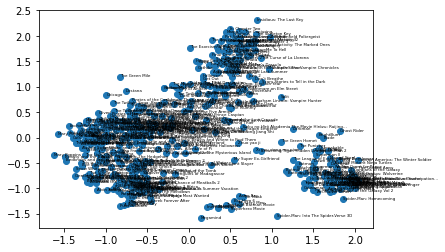

In [5]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])

for index, row in movies.iterrows():
    plt.annotate(row.title, (principal_components[index, 0], principal_components[index, 1]), fontsize=4)

plt.show()

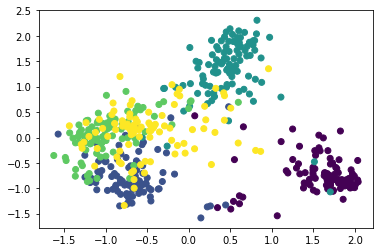

In [6]:
movies_labels = {label:index for index, label in enumerate(movies.label.unique())}
movies_colours = movies.label.map(movies_labels)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=movies_colours)
plt.show()

# Similarity

In [7]:
cos_similarity = cosine_similarity(np.array(movies.embedding.tolist()), np.array(movies.embedding.tolist()))

In [8]:
movies_index = 50
print(movies.iloc[movies_index].title)

closest_movies = cos_similarity[movies_index].argsort()[-6:][::-1]
for closest_movie in closest_movies[1:]:
    print(movies.iloc[closest_movie].title, cos_similarity[movies_index, closest_movie])

Dark Phoenix
X-Men: The Last Stand 0.8119076143304088
X-Men: Days of Future Past 0.7830244206775069
X-Men: First Class 0.748911984369288
X-Men 2 0.7461027528613671
X-Men: Apocalypse 0.7435373300777062


# Classification

In [10]:
classification_result = {'accuracy': 0}
for label in movies.label.unique():
    classification_result[label] = {}

for SEED in SEEDS:
    movies = pd.read_csv(f'./embeddings/movies_embeddings_node2vec_BFS_80_10_{SEED}.csv', index_col='id', quoting=csv.QUOTE_ALL)
    movies.embedding = movies.embedding.apply(lambda embedding: eval(embedding))
    
    X = np.array(movies.embedding.tolist())
    y = movies_colours.to_numpy()
    
    logistic_classifier = LogisticRegression(multi_class='ovr', random_state=SEED)
    predicted = cross_val_predict(logistic_classifier, X, y, cv=10)
    
    class_report = classification_report(y, predicted, target_names=movies.label.unique(), output_dict=True)
    classification_result['accuracy'] += class_report['accuracy']
    
    if SEED is SEEDS[0]:
        for label in movies.label.unique():
            classification_result[label] = Counter(class_report[label])
    else:
        for label in movies.label.unique():
            classification_result[label] += Counter(class_report[label])

classification_result['accuracy'] /= len(SEEDS)
for label in movies.label.unique():
    classification_result[label] = {key : val / len(SEEDS) for key, val in classification_result[label].items()}
    
print(classification_result)

{'accuracy': 0.8820618556701032, 'super-hero': {'precision': 0.9674870129870129, 'recall': 0.95, 'f1-score': 0.9586197406326624, 'support': 100.0}, 'kids-fiction': {'precision': 0.8079250889361222, 'recall': 0.8480000000000001, 'f1-score': 0.8273343285733216, 'support': 100.0}, 'horror': {'precision': 0.9233299406468346, 'recall': 0.938, 'f1-score': 0.9305834797140475, 'support': 100.0}, 'musical': {'precision': 0.9012672110498198, 'recall': 0.8817204301075268, 'f1-score': 0.89132044848115, 'support': 93.0}, 'fantasy': {'precision': 0.8094478088367852, 'recall': 0.7847826086956522, 'f1-score': 0.7967887307138658, 'support': 92.0}}
